In [2]:
!pip install pyspark

In [3]:
!sudo apt update

Hit:1 https://download.docker.com/linux/ubuntu focal InRelease
Hit:2 https://cli.github.com/packages stable InRelease                         
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease               
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done3m
Building dependency tree       
Reading state information... Done
3 packages can be upgraded. Run 'apt list --upgradable' to see them.


In [4]:
!sudo apt install -y openjdk-11-jdk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.25+9-1ubuntu1~20.04).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.


In [5]:
!java -version


openjdk version "11.0.25" 2024-10-15
OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu120.04)
OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu120.04, mixed mode, sharing)


### Import Libraries

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    count, when, col, mean, sum, length, to_timestamp,
    hour, dayofweek, month, year, unix_timestamp, rand, isnan, isnull
)
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

In [9]:
spark = SparkSession.builder \
    .appName("NYC_Yellow_Cab_Outlier_Detection") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [10]:
file_paths = [
    "yellow_tripdata_2024-06.parquet",
    "yellow_tripdata_2024-07.parquet",
    "yellow_tripdata_2024-08.parquet",
    "yellow_tripdata_2024-09.parquet"
]

In [11]:
df = spark.read.parquet(file_paths[0])
for path in file_paths[1:]:
    new_df = spark.read.parquet(path)
    df = df.union(new_df)

In [12]:
df.cache()

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double]

### Exploratory Data Analysis

In [23]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2024-06-01 00:03:46|  2024-06-01 00:31:23|              1|         12.5|         1|                 N|         138|         195|           1|       48.5| 7.75|    0.5|     11.5

In [24]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [25]:
df.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|     DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------

In [ ]:
df.summary().show()

+-------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+
|summary|           VendorID|   passenger_count|    trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee|
+-------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-

In [26]:
#Columns with NULL values

#Drop columns like RatecodeID, store_and_fwd_flag and impute the other NULL columns
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|        1432168|            0|   1432168|           1432168|           0|           0|           0|          0|    0|      0|         

In [27]:
df.groupBy("passenger_count").count().show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              0| 121547|
|              7|     19|
|              6|  64571|
|              5|  94228|
|              1|9095870|
|              3| 424462|
|              8|     47|
|              2|1716418|
|              4| 278968|
|           NULL|1432168|
|              9|     11|
+---------------+-------+



In [28]:
df.groupBy("congestion_surcharge").count().show()

+--------------------+--------+
|congestion_surcharge|   count|
+--------------------+--------+
|                 0.0| 1041134|
|                 2.5|10588209|
|                -2.5|  166791|
|                 1.0|       3|
|                2.52|       1|
|                NULL| 1432168|
|                0.75|       3|
+--------------------+--------+



In [29]:
df.groupBy("Airport_fee").count().show()


+-----------+--------+
|Airport_fee|   count|
+-----------+--------+
|        0.0|10635784|
|       1.25|      14|
|      -1.75|   37852|
|       1.75| 1122491|
|       NULL| 1432168|
+-----------+--------+



In [30]:
# Check for duplicate rows
total_count = df.count()
unique_count = df.dropDuplicates().count()

if total_count > unique_count:
    print(f"There are {total_count - unique_count} duplicate rows.")
else:
    print("There are no duplicate rows.")


There are 1 duplicate rows.


In [13]:
from pyspark.sql.functions import col, when

# Define numerical columns
numerical_columns = ["trip_distance", "fare_amount", "extra", "mta_tax", "tip_amount",
                     "tolls_amount", "improvement_surcharge", "total_amount",
                     "congestion_surcharge", "Airport_fee", "passenger_count"]

outlier_columns = []
for column in numerical_columns:
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.0)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Check if there are any outliers in the current column
    outlier_count = df.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
    if outlier_count > 0:
        outlier_columns.append(column)

if outlier_columns:
    print(f"Columns with outliers: {outlier_columns}")
    df.select(outlier_columns).show()
else:
    print("No columns with outliers found.")


Columns with outliers: ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'passenger_count']
+-------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|passenger_count|
+-------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|         12.5|       48.5| 7.75|    0.5|     11.55|         0.0|                  1.0|        69.3|                 0.0|       1.75|              1|
|         4.34|       20.5|  6.0|    0.5|       8.4|         0.0|                  1.0|       38.15|                 0.0|       1.75|              1|
|          1.3|       10.0|  1.0|    0.5|    

### Preprocessing

In [14]:
df = df.na.drop(subset=["RatecodeID", "store_and_fwd_flag"])

In [15]:
## Mean imputation for passenger_count, congestion_surcharge, and Airport_fee column

mean_values = df.select(
    mean("passenger_count").alias("mean_passenger_count"),
    mean("congestion_surcharge").alias("mean_congestion_surcharge"),
    mean("Airport_fee").alias("mean_airport_fee")
).collect()[0]

# Impute null values with the calculated means
df = df.na.fill({
    "passenger_count": mean_values["mean_passenger_count"],
    "congestion_surcharge": mean_values["mean_congestion_surcharge"],
    "Airport_fee": mean_values["mean_airport_fee"]
})


In [16]:
# Outlier Handling
# List of columns with outliers
outlier_columns = ["trip_distance", "fare_amount", "extra", "mta_tax", "tip_amount",
                   "tolls_amount", "improvement_surcharge", "total_amount",
                   "congestion_surcharge", "Airport_fee", "passenger_count"]

# Filter conditions for each column based on IQR
for column in outlier_columns:
    # Calculate the 25th and 75th percentiles
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.0)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Apply the filter to remove rows outside the acceptable range for this column
    df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))


In [17]:
df.describe().show()

+-------+-------------------+---------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------+------------------+------------+---------------------+------------------+--------------------+-----------+
|summary|           VendorID|passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|     DOLocationID|      payment_type|       fare_amount|             extra|mta_tax|        tip_amount|tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|Airport_fee|
+-------+-------------------+---------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------+------------------+------------+---------------------+------------------+--------------------+-----------+
|  count|            7027595|        7027595|           7027595|   

### Feature Engineering

In [18]:
# 1. Extract meaningful date and time features from 'tpep_pickup_datetime'

# Extract hour, day of week, month, and year
df = df.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
       .withColumn("pickup_dayofweek", dayofweek("tpep_pickup_datetime")) \
       .withColumn("pickup_month", month("tpep_pickup_datetime")) \
       .withColumn("pickup_year", year("tpep_pickup_datetime"))

# Calculate trip duration (in minutes) using 'tpep_pickup_datetime' and 'tpep_dropoff_datetime'
df = df.withColumn("trip_duration",
                   (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60)

# 2. Interaction Features
# Create features that represent interactions between columns

df = df.withColumn("distance_per_passenger", col("trip_distance") / col("passenger_count"))
df = df.withColumn("fare_per_distance", col("fare_amount") / col("trip_distance"))
df = df.withColumn("total_per_passenger", col("total_amount") / col("passenger_count"))

# 3. Aggregated Features
# Aggregations based on locations might be useful if there's a logical grouping for PULocationID

location_aggregates = df.groupBy("PULocationID").agg(
    mean("fare_amount").alias("avg_fare_by_location"),
    mean("trip_duration").alias("avg_duration_by_location")
)
df = df.join(location_aggregates, on="PULocationID", how="left")


In [19]:
df.show(5)

+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+----------------+------------+-----------+------------------+----------------------+------------------+-------------------+--------------------+------------------------+
|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|pickup_hour|pickup_dayofweek|pickup_month|pickup_year|     trip_duration|distance_per_passenger| fare_per_distance|total_per_passenger|avg_fare_by_location|avg_duration_by_location|
+------------+--------+--------------------+---------------------+---------------+-------------+

### Check feature imporatnce for fare price prediction

In [20]:
input_features = ["PULocationID", "VendorID", "passenger_count", "trip_distance", "RatecodeID",
                  "DOLocationID", "payment_type", "extra", "mta_tax", "tip_amount",
                  "tolls_amount", "improvement_surcharge", "congestion_surcharge",
                  "Airport_fee", "pickup_hour", "pickup_dayofweek", "pickup_month",
                  "pickup_year", "trip_duration", "distance_per_passenger",
                  "fare_per_distance", "total_per_passenger", "avg_fare_by_location",
                  "avg_duration_by_location"]
for feature in input_features:
    correlation = df.stat.corr("fare_amount", feature)
    print(f"Correlation between fare_amount and {feature}: {correlation}")


Correlation between fare_amount and PULocationID: -0.05546677276637209


Correlation between fare_amount and VendorID: 0.03323846291452299


Correlation between fare_amount and passenger_count: nan


Correlation between fare_amount and trip_distance: 0.8615263454503845


Correlation between fare_amount and RatecodeID: -0.0071207262349301005


Correlation between fare_amount and DOLocationID: -0.0776381732780068


Correlation between fare_amount and payment_type: -0.044955551020871336


Correlation between fare_amount and extra: -0.030650755290182814


Correlation between fare_amount and mta_tax: nan


Correlation between fare_amount and tip_amount: 0.41193304021199206


Correlation between fare_amount and tolls_amount: nan


Correlation between fare_amount and improvement_surcharge: nan


Correlation between fare_amount and congestion_surcharge: nan


Correlation between fare_amount and Airport_fee: nan


Correlation between fare_amount and pickup_hour: 0.02399679210210085


Correlation between fare_amount and pickup_dayofweek: 0.016381664215496076


Correlation between fare_amount and pickup_month: 0.01646363269687151


Correlation between fare_amount and pickup_year: 0.00029387813147819803


Correlation between fare_amount and trip_duration: 0.21792412802313815


Correlation between fare_amount and distance_per_passenger: 0.8615263454503845


Correlation between fare_amount and fare_per_distance: -0.11464747979174499


Correlation between fare_amount and total_per_passenger: 0.9559497906256327


Correlation between fare_amount and avg_fare_by_location: 0.19058689026560777


Correlation between fare_amount and avg_duration_by_location: 0.16894135874973493


In [21]:
# Define target and selected input features to retain
target_column = "fare_amount"
selected_features = [
    "trip_distance", "tip_amount", "trip_duration", "distance_per_passenger",
    "fare_per_distance", "total_per_passenger", "avg_fare_by_location",
    "avg_duration_by_location"
]

# Retain only the selected features and the target column
columns_to_keep = [target_column] + selected_features
df = df.select(*columns_to_keep)



In [22]:
# Display the schema to verify the DataFrame structure
df.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- distance_per_passenger: double (nullable = true)
 |-- fare_per_distance: double (nullable = true)
 |-- total_per_passenger: double (nullable = true)
 |-- avg_fare_by_location: double (nullable = true)
 |-- avg_duration_by_location: double (nullable = true)



### Building Linear Regression model

In [23]:
df = df.drop("features", "out_features")


In [24]:
df.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- distance_per_passenger: double (nullable = true)
 |-- fare_per_distance: double (nullable = true)
 |-- total_per_passenger: double (nullable = true)
 |-- avg_fare_by_location: double (nullable = true)
 |-- avg_duration_by_location: double (nullable = true)



In [25]:
# Step 1: Ensure the target column and selected features are cast to DoubleType
for column in [target_column] + selected_features:
    df = df.withColumn(column, col(column).cast(DoubleType()))

# Step 2: Remove rows with NaN, null, or infinite values in selected columns
for column in [target_column] + selected_features:
    df = df.filter(~isnan(col(column)) & ~isnull(col(column)) & (col(column) != float("inf")) & (col(column) != float("-inf")))

# Step 3: Assemble selected features into a single feature vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df = assembler.transform(df)

# Step 4: Normalize the feature vector
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

train, test = df.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="scaled_features", labelCol=target_column)

lr_model = lr.fit(train)

predictions = lr_model.transform(test)

# Step 9: Evaluate the model's performance using RMSE
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")



Root Mean Squared Error (RMSE) on test data: 0.9255823159615582


In [26]:
from pyspark.sql.functions import rand

random_predictions = predictions.select(target_column, "prediction").orderBy(rand()).limit(10)

random_predictions.show()


+-----------+------------------+
|fare_amount|        prediction|
+-----------+------------------+
|        5.8| 7.543649318155057|
|       12.8| 12.12767524814576|
|       15.6|15.803205609531865|
|       19.8|21.242059291378432|
|        7.9| 7.419465814911607|
|       17.0|15.461201704754782|
|       25.4|26.572925350549745|
|       11.4| 12.79987064813904|
|        7.2| 7.616134632137978|
|       10.0|11.868765683687219|
+-----------+------------------+



#### Relative RMSE tells us that the predicted fare amount on an average varies by 7.38% from the actual value

In [27]:
# Calculate the mean of fare_amount in the test set
mean_fare = test.select("fare_amount").groupBy().avg().first()[0]

# Calculate relative RMSE as a percentage
relative_rmse = (rmse / mean_fare) * 100
print(f"Relative RMSE: {relative_rmse:.2f}%")


Relative RMSE: 7.20%


In [28]:
df.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- distance_per_passenger: double (nullable = true)
 |-- fare_per_distance: double (nullable = true)
 |-- total_per_passenger: double (nullable = true)
 |-- avg_fare_by_location: double (nullable = true)
 |-- avg_duration_by_location: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)



### Checking for Overfitting or Underfitting

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Calculate RMSE on the Training Data
train_predictions = lr_model.transform(train)
train_rmse = evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
print(f"Training RMSE: {train_rmse}")

# Step 2: Calculate RMSE on the Test Data
test_predictions = lr_model.transform(test)
test_rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
print(f"Test RMSE: {test_rmse}")


# Step 3: Analyze Overfitting or Underfitting
if train_rmse < test_rmse * 0.7:
    print("The model might be overfitting.")
elif train_rmse > test_rmse * 1.3:
    print("The model might be underfitting.")
else:
    print("The model seems to be well-fitted.")


Training RMSE: 0.9259655217037926


Test RMSE: 0.9255823159615582
The model seems to be well-fitted.


In [ ]:
spark.stop()

### Visualiztion Plots Using Hive

In [ ]:
# Save DataFrame as a permanent Hive table
df.write.mode("overwrite").saveAsTable("nyc_yellow_cab_data")


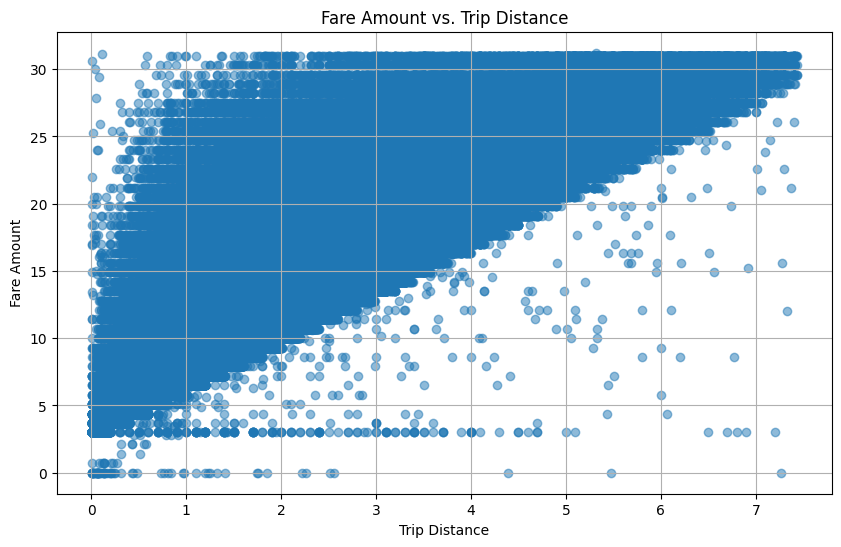

In [ ]:
fare_vs_distance = spark.sql("""
    SELECT trip_distance, fare_amount
    FROM nyc_yellow_cab_data
    WHERE trip_distance < 50
""")
fare_vs_distance_df = fare_vs_distance.toPandas()



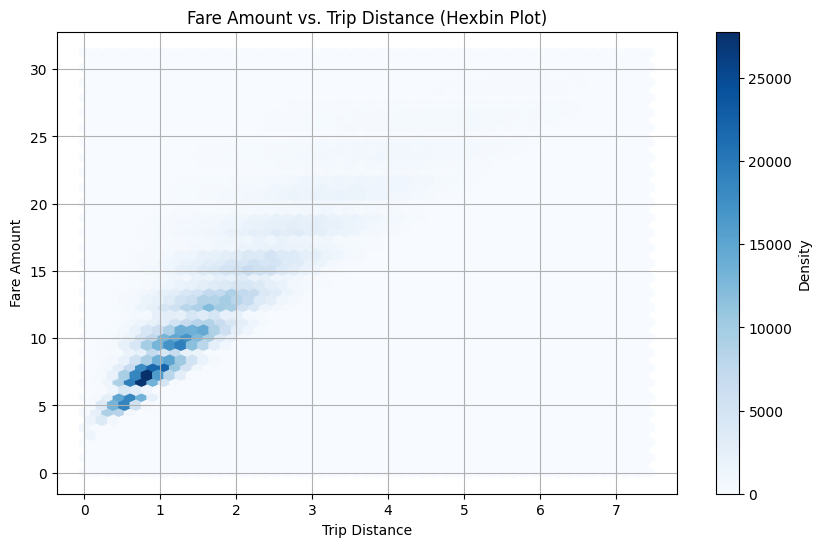

In [ ]:
# Hexbin plot
plt.figure(figsize=(10, 6))
plt.hexbin(fare_vs_distance_df["trip_distance"], fare_vs_distance_df["fare_amount"], gridsize=50, cmap="Blues")
plt.colorbar(label="Density")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Fare Amount vs. Trip Distance (Hexbin Plot)")
plt.grid(True)
plt.show()

In [ ]:
spark.stop()